# 训练方案
## STaR (Self-Taught Reasoner)
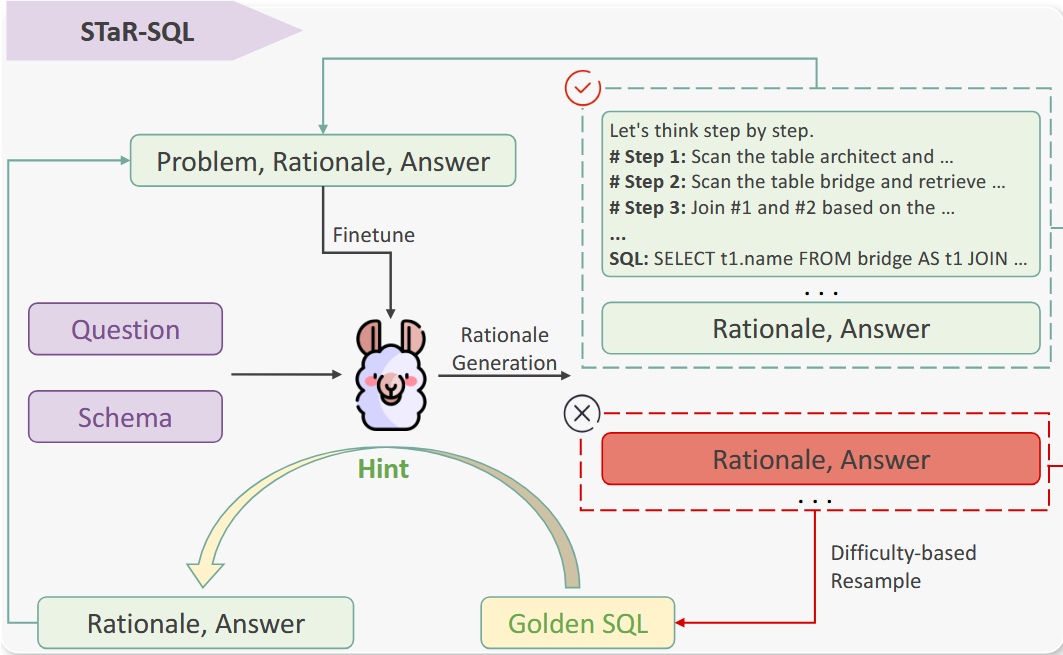

In [5]:
import os
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import pandas as pd
import re
import json
import torch
import dotenv
dotenv.load_dotenv()

def read_texts_from_dir(dir_path):
    """
    Reads the texts from a given directory and saves them in the pd.DataFrame with columns ['id', 'file_1', 'file_2'].
    
    Params:
    dir_path (str): path to the directory with data
    """
    # Count number of directories in the provided path
    dir_count = sum(os.path.isdir(os.path.join(root, d)) for root, dirs, _ in os.walk(dir_path) for d in dirs)
    data=[0 for _ in range(dir_count)]
    print(f"Number of directories: {dir_count}")
    
    # For each directory, read both file_1.txt and file_2.txt and save results to the list
    i=0
    for folder_name in sorted(os.listdir(dir_path)):
        folder_path = os.path.join(dir_path, folder_name)
        if os.path.isdir(folder_path):
          try:
            with open(os.path.join(folder_path, 'file_1.txt'), 'r', encoding='utf-8') as f1:
              text1 = f1.read().strip()
            with open(os.path.join(folder_path, 'file_2.txt'), 'r', encoding='utf-8') as f2:
              text2 = f2.read().strip()
            index = int(folder_name[-4:])
            data[i]=(index, text1, text2)
            i+=1
          except Exception as e:
            print(f"Error reading directory {folder_name}: {e}")
    
    # Change list with results into pandas DataFrame
    df = pd.DataFrame(data, columns=['id', 'file_1', 'file_2']).set_index('id')
    return df

In [2]:
# 使用datasets加载数据配合pipeline会更快数据地址是
# Use the above function to load both train and test data
data_dir = os.environ.get("ROOT_DATA_DIR")
data_name = "fake-or-real-the-impostor-hunt"
train_path=os.path.join(data_dir, data_name, "train")
df_train=read_texts_from_dir(train_path)
test_path=os.path.join(data_dir, data_name, "test")
df_test=read_texts_from_dir(test_path)

Number of directories: 95
Number of directories: 1068


In [3]:
# 定义系统提示 - 标准化输出格式
system_prompt = """You are tasked with judging the authenticity of two text samples. Given two texts labeled 1 and 2, one is real and the other is fake. 

To ensure consistent evaluation, please follow this strict output format:
1. First, you may analyze and reason through the samples (this part will not be evaluated)
2. For your final answer, you must wrap the number of the real sample (only 1 or 2) within \\boxed{}
3. Do not include any other content outside the \\boxed{} tag
4. Examples of correct format: \\boxed{1} or \\boxed{2}
5. Any output not following this format will be considered invalid"""

def create_system_prompt(answer=None):
    """
    生成包含正确答案提示的系统提示
    
    参数:
        system_prompt (str): 原始的系统提示文本
        answer (int or None): 正确答案（1或2），为None时表示无需提示
    
    返回:
        str: 处理后的系统提示文本
    """
    if answer is None:
        return system_prompt
    else:
        # 构造提示内容，包含正确答案但要求模型假装不知道
        hint_text = f"\nNote: Your previous judgment was incorrect. The correct answer is \\boxed{{{answer}}}. " \
                    f"However, please pretend you don't know this answer and re-analyze the two texts carefully. " \
                    f"Do not mention this note or the correct answer in your reasoning; just conduct a new evaluation based on the texts themselves."
        # 将提示添加到原始系统提示后
        return system_prompt + hint_text
    

def create_prompt(sample1, sample2):
    """构建提示文本，包含明确的标准化输出要求"""
    return """Below are two text samples. Determine which is real and which is fake.

Sample 1: [[sample1]]

Sample 2: [[sample2]]

Please follow these steps:
1. You may first compare their content, logical consistency, information accuracy, and language style
2. Then, provide your final answer by putting only the number of the real sample (1 or 2) within \\boxed{}
3. Ensure there is no other text outside the \\boxed{} tag

Example of correct output:
After comparing the two samples, I think Sample 1 is more consistent and accurate. Answer: \\boxed{1}

Example of incorrect output:
2 (This is missing the required boxed format)""".replace("[[sample1]]", sample1).replace("[[sample2]]", sample2)

In [6]:
# 模型路径
model_dir = os.environ.get("ROOT_MODEL_DIR")
model_name = "Qwen/Qwen3-8B"
model_path = os.path.join(model_dir, model_name)

# 加载tokenizer和模型
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="cuda:2"
)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
# 根据思维模式获取最佳采样参数
def get_sampling_parameters(enable_thinking=True):
    if enable_thinking:
        return {
            "temperature": 0.6,
            "top_p": 0.95,
            "top_k": 20,
            "min_p": 0.0,
            "do_sample": True
        }
    else:
        return {
            "temperature": 0.7,
            "top_p": 0.8,
            "top_k": 20,
            "min_p": 0.0,
            "do_sample": True
        }

# 初始化文本生成pipeline
text_generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
)

Device set to use cuda:2


In [10]:
# 处理单条数据
def judge_authenticity(sample1, sample2, enable_thinking=True, answer=None):
    try:
        sampling_params = get_sampling_parameters(enable_thinking)
        
        # 构建对话消息
        messages = [
            {"role": "system", "content": create_system_prompt(answer=answer)},
            {"role": "user", "content": create_prompt(sample1, sample2)}
        ]
        
        # 应用聊天模板
        prompt = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            enable_thinking=enable_thinking
        )
        
        # 生成结果
        result = text_generator(
            prompt,
            max_new_tokens=32768,
            return_full_text=False,** sampling_params
        )
        
        # 提取生成的文本
        generated_text = result[0]['generated_text']

        # 解析结果
        thinking_end_token = tokenizer.decode(151668) if enable_thinking else None
        
        if enable_thinking and thinking_end_token in generated_text:
            _, content = generated_text.split(thinking_end_token, 1)
        else:
            content = generated_text
        
        # 清理结果 - 使用正则提取boxed中的数字
        content = content.strip()
        match = re.search(r'\\boxed\{([12])\}', content)
        answer = None
        
        if match:
            answer = match.group(1)
        else:
            match = re.search(r'\{([12])\}', content)
            if match:
                answer = match.group(1)
            elif "1" in content[-25:] and "2" not in content[-25:]:
                answer = '1'
            elif "1" not in content[-25:] and "2" in content[-25:]:
                answer = '2'
            else:  
                print(f"警告: 无效的判断结果 - {content[-50:]}...，默认返回1")
                answer = '1'
        
        # 返回包含思考过程和答案的字典
        return {
            'generated_text': generated_text,
            'real_text_id': answer
        }
        
    except Exception as e:
        print(f"错误: 处理样本时出错 - {str(e)}，默认返回1")
        # 错误情况下也返回标准结构
        return {
            'generated_text': f"错误: 处理样本时出错 - {str(e)}",
            'real_text_id': '1'
        }


def process_all_samples(df, enable_thinking=True):
    results = []
    total_samples = len(df)
    gold_df = pd.read_csv(os.path.join(data_dir, data_name, "train.csv"))
    
    for idx, row in df.iterrows():
        # 修正1：使用values[0]而非value[0]，且增加存在性检查
        gold_id_row = gold_df.loc[gold_df["id"] == idx, "id"]
        assert len(gold_id_row) > 0, f"gold_df中不存在id={idx}的记录"
        assert idx == gold_id_row.values[0], "sample id不匹配!!!"
        
        # 每处理5个样本显示一次进度
        if idx % 5 == 0:
            print(f"处理进度: {idx}/{total_samples}")
            
        sample1 = row.iloc[0]
        sample2 = row.iloc[1]
        
        result = judge_authenticity(sample1, sample2, enable_thinking)
        count = 3
        
        real_label_series = gold_df.loc[gold_df["id"] == idx, "real_text_id"]
        real_label = str(real_label_series.values[0])  # 正确的写法是values[0]

        print("idx:", idx, "real_lable:", real_label, "pred_label:", result["real_text_id"])
        # 修正4：循环条件中使用缓存的真实标签
        while result["real_text_id"] != real_label and count > 0:
            result = judge_authenticity(sample1, sample2, enable_thinking, answer=real_label)
            count -= 1
            print("Count:", count, "给定Hint的推理结果：", result)
        
        # 修正5：最终判断使用缓存的真实标签
        if result["real_text_id"] == real_label:
            result["equal"] = 1  
        else:
            result["equal"] = 0
            print("equal = 0", result)
        
        results.append({'id': idx,** result})

        # 每处理10个样本打印一次结果
        if idx % 10 == 0:
            print(result)
    
    output_df = pd.DataFrame(results)
    return output_df


In [ ]:
output_df = process_all_samples(df_train, enable_thinking=True)
# 显示结果
print(output_df.head())
# 保存结果
output_df.to_csv("data/star_train.csv", index=False)

处理进度: 0/95
idx: 0 real_lable: 1 pred_label: 1
{'generated_text': '<think>\nOkay, let\'s tackle this problem. I need to determine which of the two samples is real and which is fake. Let me start by carefully reading both texts and comparing them.\n\nSample 1 talks about the VIRSA project, which seems to be a real astronomical project. It mentions specific details like the use of standard stars, data accessible via ESO\'s Science Archive Facility, and specific surveys like VVV and VMC. The text also references the ESO Telescope Bibliography with over 300 articles, which sounds credible. The technical terms and the structure of the information seem accurate. The mention of specific datasets, like calibrated images and photometric catalogs, aligns with what I know about astronomical data processing. Also, the numbers mentioned (like over half a petabyte) and the collaborative nature of the project with peer-reviewed articles make it seem authentic.\n\nSample 2, on the other hand, mentions 

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Count: 2 给定Hint的推理结果： {'generated_text': '<think>\nOkay, let\'s take a look at these two samples. The task is to determine which one is real and which is fake. \n\nStarting with Sample 1. The topic is the Stellar Initial Mass Function (IMF). The text explains that IMF estimates how many stars form at different masses during star formation. It mentions the importance of understanding this distribution for galaxy formation, and the challenges in measuring it, like distance estimations, ages, metal content, dust clouds, binary systems, and stellar lifespans. The language here is technical, using terms like "interstellar gas," "metal content," "binary systems," and "stellar lifespans." The structure seems logical, discussing the concept, its significance, and the difficulties in measurement. The information seems accurate based on what I know about astrophysics. The text is detailed and specific, which makes it sound like a real academic or scientific text.\n\nNow, Sample 2 talks about din